In [1]:
import typing
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/sunyamare/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sunyamare/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
random_state = 8

In [3]:
data = dict()
dataset_names = ['train', 'valid', 'test']

for dataset_name in dataset_names:
    df = pd.read_csv(f"data/{dataset_name}.csv")
    data.update({dataset_name: {'df': df}})

data.keys()

dict_keys(['train', 'valid', 'test'])

In [4]:
data['train'].keys()

dict_keys(['df'])

In [5]:
# total rows of all data
sum(data[dataset_name]['df'].shape[0] for dataset_name in dataset_names)

23486

In [6]:
# data['train']['df'].head()
data['train']['df'].sample(5)

,ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
498,624,634,69,Overpriced but so comfortable,This is a great beach/pool or lounge piece. i ...,4,1,12,General Petite,Intimate,Lounge
16257,20304,1035,40,Love these jeans!,I love these jeans. they can be dressed up or ...,5,1,0,General Petite,Bottoms,Jeans
12158,15238,862,64,Stylish tee,Another wonderful deletta top is hanging in my...,5,1,0,General Petite,Tops,Knits
2743,3422,939,58,Wanted to like this...,The craftmanship & material (not itchy at all ...,4,1,0,General,Tops,Sweaters
11606,14545,904,66,Great drape!,I love how this long sweater drapes. it's soft...,5,1,0,General Petite,Tops,Fine gauge


In [7]:
data['train']['df'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790 entries, 0 to 18789
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       18790 non-null  int64 
 1   Clothing ID              18790 non-null  int64 
 2   Age                      18790 non-null  int64 
 3   Title                    15773 non-null  object
 4   Review Text              18131 non-null  object
 5   Rating                   18790 non-null  int64 
 6   Recommended IND          18790 non-null  int64 
 7   Positive Feedback Count  18790 non-null  int64 
 8   Division Name            18781 non-null  object
 9   Department Name          18781 non-null  object
 10  Class Name               18781 non-null  object
dtypes: int64(6), object(5)
memory usage: 1.6+ MB


<AxesSubplot: >

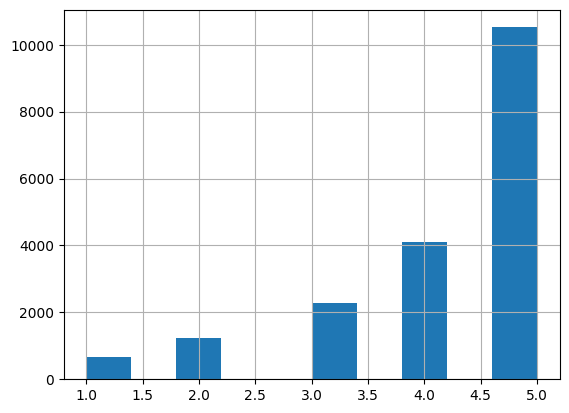

In [8]:
data['train']['df']['Rating'].hist()

In [9]:
def get_df_copy_fillna(df, columns):
    return df[columns].copy().fillna('')

In [10]:
tokenizer = TweetTokenizer()
stop_words = set(stopwords.words("english"))
keep_stop_words = ['not', 'no', 'against', 'above', 'below']
for word in keep_stop_words:
    stop_words.remove(word)
print('Removed stopwords:', stop_words)
lemmatizer = WordNetLemmatizer()

def tokenize_text(text: str):
    if (not isinstance(text, str)):
        raise ValueError(f"The text {text} isn't a string!")

    # Change 't to 'not'
    text = re.sub(r"n\'t", " not", text)
    
    text = text.lower()

    word_tokens = tokenizer.tokenize(text)

    filtered_words_tokens = [w for w in word_tokens if not w in stop_words]

    lemmatized_text = [lemmatizer.lemmatize(w) for w in filtered_words_tokens]
    
    return ' '.join(lemmatized_text)

Removed stopwords: {'too', 'this', 'hers', 'his', 'both', 'him', 'has', 'y', 's', "haven't", "mightn't", "shouldn't", 'so', "it's", 'now', 'mustn', 'your', 'we', 'of', 'about', 'up', 'a', "hadn't", 'hasn', 'm', 'their', 'theirs', 'what', "aren't", 'don', 'my', 'you', "that'll", "isn't", 'she', 'from', 'why', 'such', 'hadn', 'will', 'them', 'is', 'have', 'our', "you've", 'himself', 'nor', 'shan', 'down', 'shouldn', 'ain', 'which', 'these', 'same', 'yourself', "mustn't", 'further', 'needn', 'its', 'the', 'then', 'doesn', 'haven', "wouldn't", "she's", 'itself', 'by', 'who', 'when', 'few', 'isn', "didn't", 'wasn', 'or', 'out', 'does', 'other', 'he', 'very', 'having', 'where', 'aren', "you'll", "wasn't", 'each', "should've", 'over', 'am', "won't", 'how', 'wouldn', 'only', "hasn't", 'just', "needn't", "doesn't", 'because', 'didn', "you'd", 'being', 've', 'ourselves', 'herself', 't', 'and', 'as', 'll', 'me', 'that', 'at', 'under', 're', 'yourselves', 'any', 'once', 'been', "you're", 'did', "d

In [11]:
def get_tokenized_X(X):
    return [tokenize_text(text) for text in X]

In [12]:
def get_tfidf_vectorizer(X_train, ngram_range=(1, 1)):
    # settings inspired by https://www.linkedin.com/pulse/another-twitter-sentiment-analysis-python-part-5-tfidf-ricky-kim/
    # TODO consider options: max_df=0.9, min_df=2
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_vectorizer.fit(get_tokenized_X(X_train))

    return tfidf_vectorizer

In [13]:
def get_vectorized_X(X, vectorizer):
    tokenized_X = get_tokenized_X(X)

    vectorized_X = vectorizer.transform(tokenized_X)

    return vectorized_X.toarray()

In [15]:
X_y_train_title_rating = get_df_copy_fillna(data['train']['df'], ['Title', 'Rating'])
X_y_valid_title_rating = get_df_copy_fillna(data['valid']['df'], ['Title', 'Rating'])
X_y_test_title_rating = get_df_copy_fillna(data['test']['df'], ['Title', 'Rating'])

X_y_train_title_rating.head(2)

,Title,Rating
0,,4
1,,5


In [16]:
X_y_train_reviewtext_rating = get_df_copy_fillna(data['train']['df'], ['Review Text', 'Rating'])
X_y_valid_reviewtext_rating = get_df_copy_fillna(data['valid']['df'], ['Review Text', 'Rating'])
X_y_test_reviewtext_rating = get_df_copy_fillna(data['test']['df'], ['Review Text', 'Rating'])

X_y_train_reviewtext_rating.head(2)

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5


In [17]:
title_vectorizer = get_tfidf_vectorizer(X_y_train_title_rating['Title'], (1, 3))
reviewtext_vectorizer = get_tfidf_vectorizer(X_y_train_reviewtext_rating['Review Text'], (1, 3))

In [18]:
X_train_title = get_vectorized_X(X_y_train_title_rating['Title'], title_vectorizer)
X_valid_title = get_vectorized_X(X_y_valid_title_rating['Title'], title_vectorizer)

X_train_reviewtext = get_vectorized_X(X_y_train_reviewtext_rating['Review Text'], reviewtext_vectorizer)
X_valid_reviewtext = get_vectorized_X(X_y_valid_reviewtext_rating['Review Text'], reviewtext_vectorizer)

In [20]:
y_train_title = X_y_train_title_rating['Rating'].tolist()
y_valid_title = X_y_valid_title_rating['Rating'].tolist()

y_train_reviewtext = X_y_train_reviewtext_rating['Rating'].tolist()
y_valid_reviewtext = X_y_valid_reviewtext_rating['Rating'].tolist()

In [21]:
print(len(X_train_title), len(y_train_title))

print(len(X_valid_title), len(y_valid_title))

18790 18790
2348 2348


In [22]:
nb_title = MultinomialNB()
nb_title.fit(X_train_title, y_train_title)
y_pred_title = nb_title.predict(X_valid_title)
accuracy = accuracy_score(y_valid_title, y_pred_title)
print("Naive Bayes Accuracy: ", accuracy)

Naive Bayes Accuracy:  0.5924190800681431


In [23]:
logreg_title = LogisticRegression(random_state=random_state, solver="saga", max_iter=200)
logreg_title.fit(X_train_title, y_train_title)
y_pred_title = logreg_title.predict(X_valid_title)
accuracy = accuracy_score(y_valid_title, y_pred_title)
print("Logistic Regression Accuracy: ", accuracy)

Logistic Regression Accuracy:  0.6158432708688245


---

In [24]:
nb_reviewtext = MultinomialNB()
nb_reviewtext.fit(X_train_reviewtext, y_train_reviewtext)
y_pred_reviewtext = nb_reviewtext.predict(X_valid_reviewtext)
accuracy = accuracy_score(y_valid_reviewtext, y_pred_reviewtext)
print("Naive Bayes Accuracy: ", accuracy)

Naive Bayes Accuracy:  0.5549403747870528


In [25]:
# data['train']['df']['Division Name'].fillna('').unique() # array(['Initmates', 'General', 'General Petite', ''], dtype=object)

In [30]:
def get_unique_values(df: pd.Series):
    return df.unique().tolist()

def preprocess_df(df: pd.DataFrame):
    df = df.copy(deep=True)

    division_name_unique_values = get_unique_values(df['Division Name'])
    df['Division Name Numeric'] = df['Division Name'].apply(division_name_unique_values.index)
    df.drop(['Division Name'], axis=1, inplace=True)

    department_name_unique_values = get_unique_values(df['Department Name'])
    df['Department Name Numeric'] = df['Department Name'].apply(department_name_unique_values.index)
    df.drop(['Department Name'], axis=1, inplace=True)

    class_name_unique_values = get_unique_values(df['Class Name'])
    df['Class Name Numeric'] = df['Class Name'].apply(class_name_unique_values.index)
    df.drop(['Class Name'], axis=1, inplace=True)

    X_title = get_vectorized_X(get_df_copy_fillna(df, ['Title'])['Title'], title_vectorizer)
    df['Title Sentiment'] = logreg_title.predict(X_title)
    df.drop(['Title'], axis=1, inplace=True)

    X_reviewtext = get_vectorized_X(get_df_copy_fillna(df, ['Review Text'])['Review Text'], reviewtext_vectorizer)
    df['Review Text Sentiment'] = nb_reviewtext.predict(X_reviewtext)
    df.drop(['Review Text'], axis=1, inplace=True)

    return df

In [31]:
for dataset_name in data.keys():
    print(f"--- Preprocessing dataset {dataset_name}...")

    preprocessed_df = preprocess_df(data[dataset_name]['df'])
    data[dataset_name]['pp_df'] = preprocessed_df

--- Preprocessing dataset train...


: 

: 

In [ ]:
data['train']['pp_df'].head(10)

,ID,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name Numeric,Department Name Numeric,Class Name Numeric,Title Sentiment,Review Text Sentiment
0,0,767,33,4,1,0,0,0,0,5,5
1,1,1080,34,5,1,4,1,1,1,5,5
2,3,1049,50,5,1,0,2,2,2,5,5
3,4,847,47,5,1,6,1,3,3,5,5
4,6,858,39,5,1,1,2,3,4,5,5
5,9,1077,34,5,1,0,1,1,1,5,5
6,10,1077,53,3,0,14,1,1,1,3,5
7,11,1095,39,5,1,2,2,1,1,5,5
8,13,767,44,5,1,0,0,0,0,4,5
9,14,1077,50,3,1,1,1,1,1,4,5


In [ ]:
print([text for text in data['train']['pp_df']['Rating'][:10]])

[4, 5, 5, 5, 5, 5, 3, 5, 5, 3]
